#This Project is developed to take a wav file of a single voice of music and get the musical pitch at any time frame.

Testing with ShortTimeFFT SciPy


Imports:

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import statistics
import random
import math
import librosa
import json
import os
import glob

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann

Name of User (used in application)

In [159]:
userId = 'user'

ONLY SET TO TRUE DURING TESTING: graphs every segment of audio (largely increases run time)

In [160]:
fullgraph = False

if fullgraph == True:
    files = glob.glob('./data/processed/plotPartial/*.png')
    for f in files:
        os.remove(f)

Load audio file (only accepts .wav file)

In [161]:
fileName = "sample7.wav"
originalFileLoc = "./data/raw/" + fileName
x, sr = librosa.load(originalFileLoc)
audioDuration = librosa.get_duration(y=x, sr=sr)

Set values

In [162]:
#What decimal to round time / signal too
defaultDecimalRate = 5
#Rate to lower bit by
defaultLoweringRate = 3
#How long each frequency reading should be (in seconds)
defaultDurationTime = 0.1

defaultMinDist = defaultDurationTime

pitchToLetter = {
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B'
}

pitches = {0: 65.406}
currentPitch = 0
while currentPitch <= 71:
    prevPitch = pitches[currentPitch]
    currentPitch += 1            
    pitches[currentPitch] = prevPitch * (2 ** (1/12))

(optional) show audio file for comparison (musicSample.png for demo)

In [163]:
# music file = musicSample.png
timeListSample = [0, 2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 16]
pitchListSample = [14, 14, 16, 16, 18, 18, 19, 19, 21, 21, 23, 23, 25, 25, 26, 26]

for i in range(len(pitchListSample)):
    pitchListSample[i] += 24

gradingDictSample = {}
for i in range(len(timeListSample) // 2):
    gradingDictSample[timeListSample[i * 2]] = {
        "startTime": timeListSample[i * 2],
        "pitchClass": pitchListSample[i * 2],
        "endTime": timeListSample[(i * 2) + 1]
    }


Get notes from freq

In [164]:
def freqToNotes(freqList):
    retFreqList = []
    for x in freqList:
        if (x >= 65.406):
            retFreqList.append((12 * math.log((500 * x) / 32523)) / (math.log(2)))
        else: 
            retFreqList.append(-1)
    return retFreqList

Create Functions

In [165]:
def is_close(a, b, tolerance=1e-2):
       return abs(a - b) < tolerance

def lowerRate(lst, rte, decimalRate):
    """(List of signal, updated rate (x))
    Used to lower bitrate by a factor of x to fix fuzz"""
    retList = []
    for i in range(int(len(lst) / rte) - 1):
        includedIndices = [lst[i * rte]]
        for j in range(rte):
            includedIndices.append(lst[(i * rte) + j + 1])
        retList.append(round(statistics.median(includedIndices),decimalRate))
    return (retList)

Pitch Analyzer Class:

In [166]:

class PitchAnalyzer:
    def __init__(self, filename, decimalRate = defaultDecimalRate, loweringRate = defaultLoweringRate, minDist = defaultMinDist, durationTime = defaultDurationTime):
        self.decimalRate = decimalRate
        self.loweringRate = loweringRate
        self.minDist = minDist
        self.durationTime = durationTime
        self.freqDict = {}
        
        
        spf = wave.open(filename, "r")
        signal = spf.readframes(-1)
        signal = np.frombuffer(signal, np.int16)
        
        frameRate = spf.getframerate()
        
        print(frameRate)
        
        my_signal = signal  # <-- your data here
        fs = frameRate                 # <-- your sampling frequency (e.g., 1000 for 1kHz)
        N = len(my_signal)
        
        g_std = 400                       # Adjust based on window length
        window_length = 1562              # Or another suitable segment length
        w = hann(window_length, sym=True)
        hop = 780                    # Hop size between windows (can be <window_length for overlap)
        mfft = 4096                      # FFT length (zero-padding)
        
        SFT = ShortTimeFFT(w, hop=hop, fs=fs, mfft=mfft, scale_to='magnitude')
        Sx = SFT.stft(my_signal)

        # Use your actual STFT (Sx), sampling frequency (fs), and signal length (N)
        # Sx = ...      # STFT matrix: freq bins x time frames (already computed)
        # fs = ...      # sampling rate (e.g., 1000)
        # N = ...       # length of my_signal (in samples)

        freqs = np.linspace(0, fs / 2, Sx.shape[0])  # Positive frequencies

        dt = (N / fs) / Sx.shape[1]                  # Time per STFT frame
        times = np.arange(Sx.shape[1]) * dt          # Center-times for frames

        segment_length_seconds = 0.5
        segments = int((N / fs) / segment_length_seconds)

        median_freqs = []
        segment_times = []

        for i in range(segments):
            start_time = i * segment_length_seconds
            end_time = (i + 1) * segment_length_seconds
            indices = np.where((times >= start_time) & (times < end_time))[0]
            if len(indices) == 0:
                continue
            segment_data = Sx[:, indices]
            magnitudes = np.abs(segment_data).flatten()  # Take magnitudes here

            repeated_freqs = np.repeat(freqs, len(indices))

            # Weighted median calculation
            sorted_idx = np.argsort(repeated_freqs)
            sorted_freqs = repeated_freqs[sorted_idx]
            sorted_magnitudes = magnitudes[sorted_idx]
            cum_weights = np.cumsum(sorted_magnitudes) / np.sum(sorted_magnitudes)
            median_freq = np.interp(0.5, cum_weights, sorted_freqs)

            median_freqs.append(median_freq)
            segment_times.append(start_time)


        plt.plot(segment_times, median_freqs, marker='o')
        plt.xlabel('Time [s]')
        plt.ylabel('Median Frequency [Hz]')
        plt.title('Median Frequency in 1/2-Second Intervals')
        plt.grid(True)
        plt.show()




        
        
        
        
        timeList = []
        
        newDuration = (len(signal) / frameRate)
        if is_close(newDuration / 2, audioDuration): 
            for i in range(len(signal)):
                timeList.append(round((i / 2) / frameRate,self.decimalRate))
                
        else:
            for i in range(len(signal)):
                timeList.append(round(i / frameRate,self.decimalRate))
                

        
        
        
            
        if self.loweringRate != 1:
            signal = lowerRate(signal, self.loweringRate, self.decimalRate)
            timeList = lowerRate(timeList, self.loweringRate, self.decimalRate)
            
            
        self.signal = signal.copy()
        self.timeList = timeList.copy()
        self.length = timeList[-1]
        
    def createWavGraph(self, fileLoc):
        
        plt.figure(1)
        plt.title("Musical Plot of: " + fileLoc)
        plt.plot(self.timeList, self.signal)
        
        # for i in (changesOfDerivative):
        #     plt.plot(timeList[i], signal[i], 'ro')
        #     plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # for i in (antiPeaks):
        #     plt.plot(timeList[i], signal[i], 'bo')
        
        plt.savefig(fileLoc)
        plt.show()
        plt.close()

        # plt.savefig('my_plot.png')
        
    def gradeSelf(self, gradingDict):
        
        #Grade by (weighed median towards lower grade / classic median)
        
        noteGradeList = []
        for i in gradingDict:
            currentGradedDict = gradingDict[i]
            
            userPitchList = []
            currentTime = currentGradedDict["startTime"]
            while currentTime <= currentGradedDict["endTime"]:
                currentTime = round(currentTime, defaultDecimalRate)
                if currentTime in self.freqDict:
                    userPitchList.append(self.freqDict[currentTime]['pitchClass'] + self.freqDict[currentTime]['cents_innacurate'])
                currentTime += defaultDurationTime
            
            pitchDifferenceList = []
            for j in userPitchList:
                pitchDifferenceList.append(min([((j%12) - (currentGradedDict["pitchClass"]%12))], key=abs))
            medianSquareError = statistics.median(pitchDifferenceList)
            noteGradeList.append(medianSquareError)
            
        
            
            
        return(noteGradeList)
            
    def createFinalGrade(self, gradingDict):
        noteGradeList = self.gradeSelf(gradingDict)
        retGrade = 100.0
        totalNotes = len(noteGradeList)
        for i in noteGradeList:
            thisGrade = abs(i) ** 2
            if thisGrade >= 1:
                thisGrade = 1
            retGrade -= thisGrade * (100/totalNotes)
        return(retGrade)
    
    def graphPitches(self, fileLoc):
        retFreqList = []
        retTimeList = []
        
        i = 0
        
        # timeListSample = [0, 2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 16]
        # pitchListSample = [14, 14, 16, 16, 18, 18, 19, 19, 21, 21, 23, 23, 25, 25, 26, 26]
        
        while i < self.length - 0.1:
            j = 0
            while round(i + j,0) not in timeListSample:
                j += 0.1
            idealPitchClass = pitchListSample[timeListSample.index(round(i+j,0))]
            
            try:
                if fullgraph == False:
                    retFreqList.append(self.getPitchAtTime(i, idealPitch = idealPitchClass))
                if fullgraph == True:
                    retFreqList.append(self.getPitchAtTime(i, fileName = ("./data/processed/plotPartial/plot[t=" + str(round(i, defaultDecimalRate)) + "-" + str(round(i + self.durationTime, defaultDecimalRate)) + "]" + userId + ".png")))
                    print("Completed t=" + str(i) + "-" + str(i + self.durationTime))
                retTimeList.append(i)
            except Exception as err:
                print(err)
                pass

            i += self.durationTime
            
        
        
        if fullgraph == False: 
            specTimeLoc = retTimeList[random.randint(0,len(retTimeList) - 1)]
            self.getPitchAtTime(specTimeLoc, fileName = ("./data/processed/plotPartial" + userId + ".png"))
            
        self.createWavGraph(fileLoc = ("./data/processed/plotFull" + userId + ".png"))

        retFreqList = freqToNotes(retFreqList)

        timeFreqDict = {}
        for i in range(len(retTimeList)):
            currentPitchClass = retFreqList[i]
            currentNoteName = round(currentPitchClass, 0)
            currentNoteCents = currentPitchClass - currentNoteName
            currentNoteName %= 12
            currentNoteName = pitchToLetter[currentNoteName]
            retDict = {
                "pitchClass" : round(currentPitchClass, 0),
                "noteName" : currentNoteName,
                "cents_innacurate" : currentNoteCents,
            }
            timeFreqDict[round(retTimeList[i], defaultDecimalRate)] = retDict
            
        self.freqDict = timeFreqDict
        
        with open("./data/processed/timeFreq.json", "w") as outfile:
            json.dump(timeFreqDict, outfile)


        plt.figure(1)
        plt.title("Pitch class error over time (seconds)" )
        plt.axhline(y=0, color='blue', linestyle='--')
        plt.plot(timeListSample[::2], self.gradeSelf(gradingDictSample), color = 'red', label = "Inaccuracy")
        plt.show()
        plt.savefig(fileLoc)
        plt.close()    
        
        
        
         


    def getPitchAtTime(self, startTime, fileName = False, durationTime = False, idealPitch = False):
        """(Start time in seconds, End time in seconds, name of .wav file)
        Returns most common frequency at the listed time"""
        
        #MEW IDEA TO GO THROUGH ALL FREQUENCIES IN LIST AND ONLY TAKE SIMILAR ~90% values to lowest value, acceptableFreqPercent variable
        
        if (durationTime == False):
            durationTime = self.durationTime
        
        decimalRate = self.decimalRate
        
        startTime = round(startTime, decimalRate)
        durationTime = round(durationTime, decimalRate)
        
        signal = self.signal.copy()
        timeList = self.timeList.copy()
    
        while(startTime not in timeList):
            startTime = round(startTime + 1 / 10 ** decimalRate,decimalRate)
        startIndex = int(timeList.index(startTime))
        while (startTime + durationTime not in timeList):
            durationTime += 1 / 10 ** decimalRate
            durationTime = round(durationTime, decimalRate)
        endIndex = int(timeList.index(startTime + durationTime))

        signal = signal[startIndex:endIndex]

        fft_output = np.fft.fft(signal)
        n = len(signal)
        frequencies = np.fft.fftfreq(n, d=1/sr)
        

        
        
        if (idealPitch == False):

            firstFreq = abs(frequencies[np.argmax(np.abs(fft_output))])
            retFreq = firstFreq
            secondFreq = abs(frequencies[np.argsort(np.abs(fft_output))[-3]])
            
            if secondFreq > firstFreq:
                topFreqs = freqToNotes([secondFreq, firstFreq])
                print(topFreqs)
                
                if abs(((topFreqs[0] - topFreqs[1])%12) - 6) < 2:
                    print("Swap successful")
                    retFreq = secondFreq
                
                
            
            
            
            if (fileName != False):
            
                plt.figure(figsize=(10, 5))
                plt.title("Musical Plot of: " + fileName + ", Current Freq = " + str(retFreq))
                plt.plot(frequencies[:n//2], np.abs(fft_output[:n//2]))
                plt.xlabel('Pitch Class Difference')
                plt.ylabel('Magnitude')
                plt.grid(True)

                plt.savefig(fileName)
                plt.close()
            
            return(retFreq)
        
        else:
            for i in range(7):
                j = i - 3
                idealFreq = 2**(((idealPitch+(12*j))-33)/12) * 440
                for freq in abs(frequencies[np.argsort(np.abs(fft_output))[-11:]]):
                    if abs(freq - idealFreq)/idealFreq < 0.1:
                        return(freq)
                # print("False, ", idealFreq, abs(frequencies[np.argsort(np.abs(fft_output))[-11:]]))
            return(abs(frequencies[np.argmax(np.abs(fft_output))]))
            

Create analyzer

48000


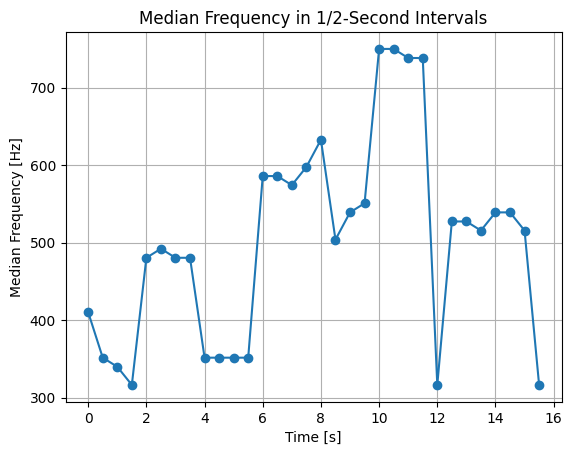

In [167]:
thisAnalyzer = PitchAnalyzer(originalFileLoc)

Graph all pitches

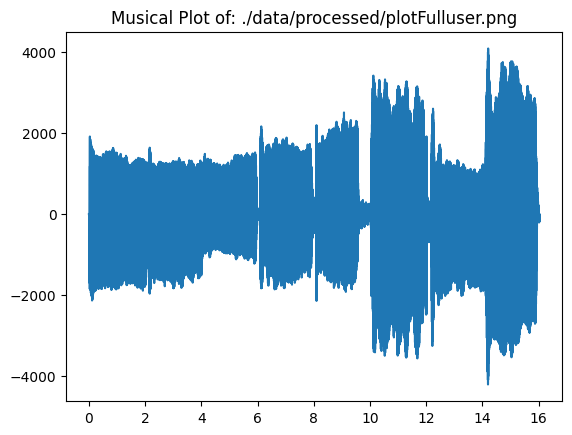

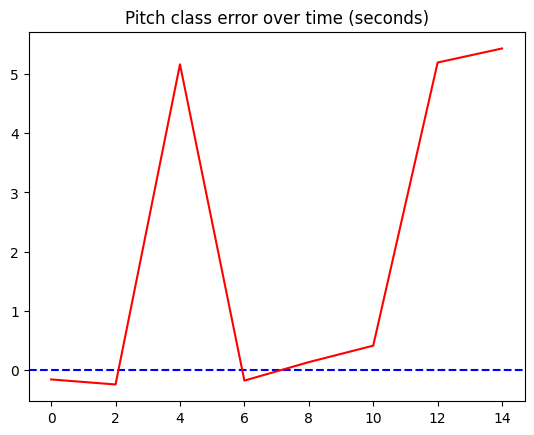

In [168]:
thisAnalyzer.graphPitches("./data/processed/pitchesPlotFull" + userId + ".png")

In [169]:
print(thisAnalyzer.gradeSelf(gradingDictSample))
print(thisAnalyzer.createFinalGrade(gradingDictSample))

[-0.1572340132878267, -0.24240711105919388, 5.163240097776406, -0.17678402194170673, 0.13495691336704851, 0.4128516199272525, 5.193606939328664, 5.430728854897911]
58.707547982716704
